In [7]:
# Importamos las librerias con las cuales trabajaremos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

df_crabs = pd.read_csv("crabs.csv")

## Tratamiento de valores atipicos (outlayers)

Vamos a ver cuantos outlayer existen en nuestras variables de interes para ello usaremos el rango intercuartil

In [8]:
variables = ['new_weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

print("El dataset tiene {} registros".format(df_crabs.shape[0] + 1))
for var in variables:
    Q1 = df_crabs[var].quantile(0.25)
    Q3 = df_crabs[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_crabs[(df_crabs[var] < lower_bound) | (df_crabs[var] > upper_bound)]
    print(f"Número de outliers en '{var}' (basado en IQR): {outliers.shape[0]}")

El dataset tiene 3887 registros
Número de outliers en 'new_weight' (basado en IQR): 28
Número de outliers en 'Shucked Weight' (basado en IQR): 41
Número de outliers en 'Viscera Weight' (basado en IQR): 24
Número de outliers en 'Shell Weight' (basado en IQR): 33


### Uso de la transformacion Box-Cox 

Una vez identificados los outlayers es necesario tomar accion sobre ellos para tratarlos, en este caso usamos la transformacion Box-Cox, notaras un cambio tanto en las graficas como en la matriz de correlacion depues de aplicados estos cambios

Si quieres enteder esta transformacion un poco mas hay un notebook en la carpeta 1-Teoria_proyecto en la que se explica este consepto

# Aplicando Transformación Box-Cox...
Advertencia: La columna 'Height' contiene valores no positivos (cero o negativos). Se le sumará una pequeña constante para aplicar Box-Cox.
Transformación Box-Cox aplicada exitosamente.

---
## Visualización de Variables Originales vs. Transformadas (Box-Cox)
---


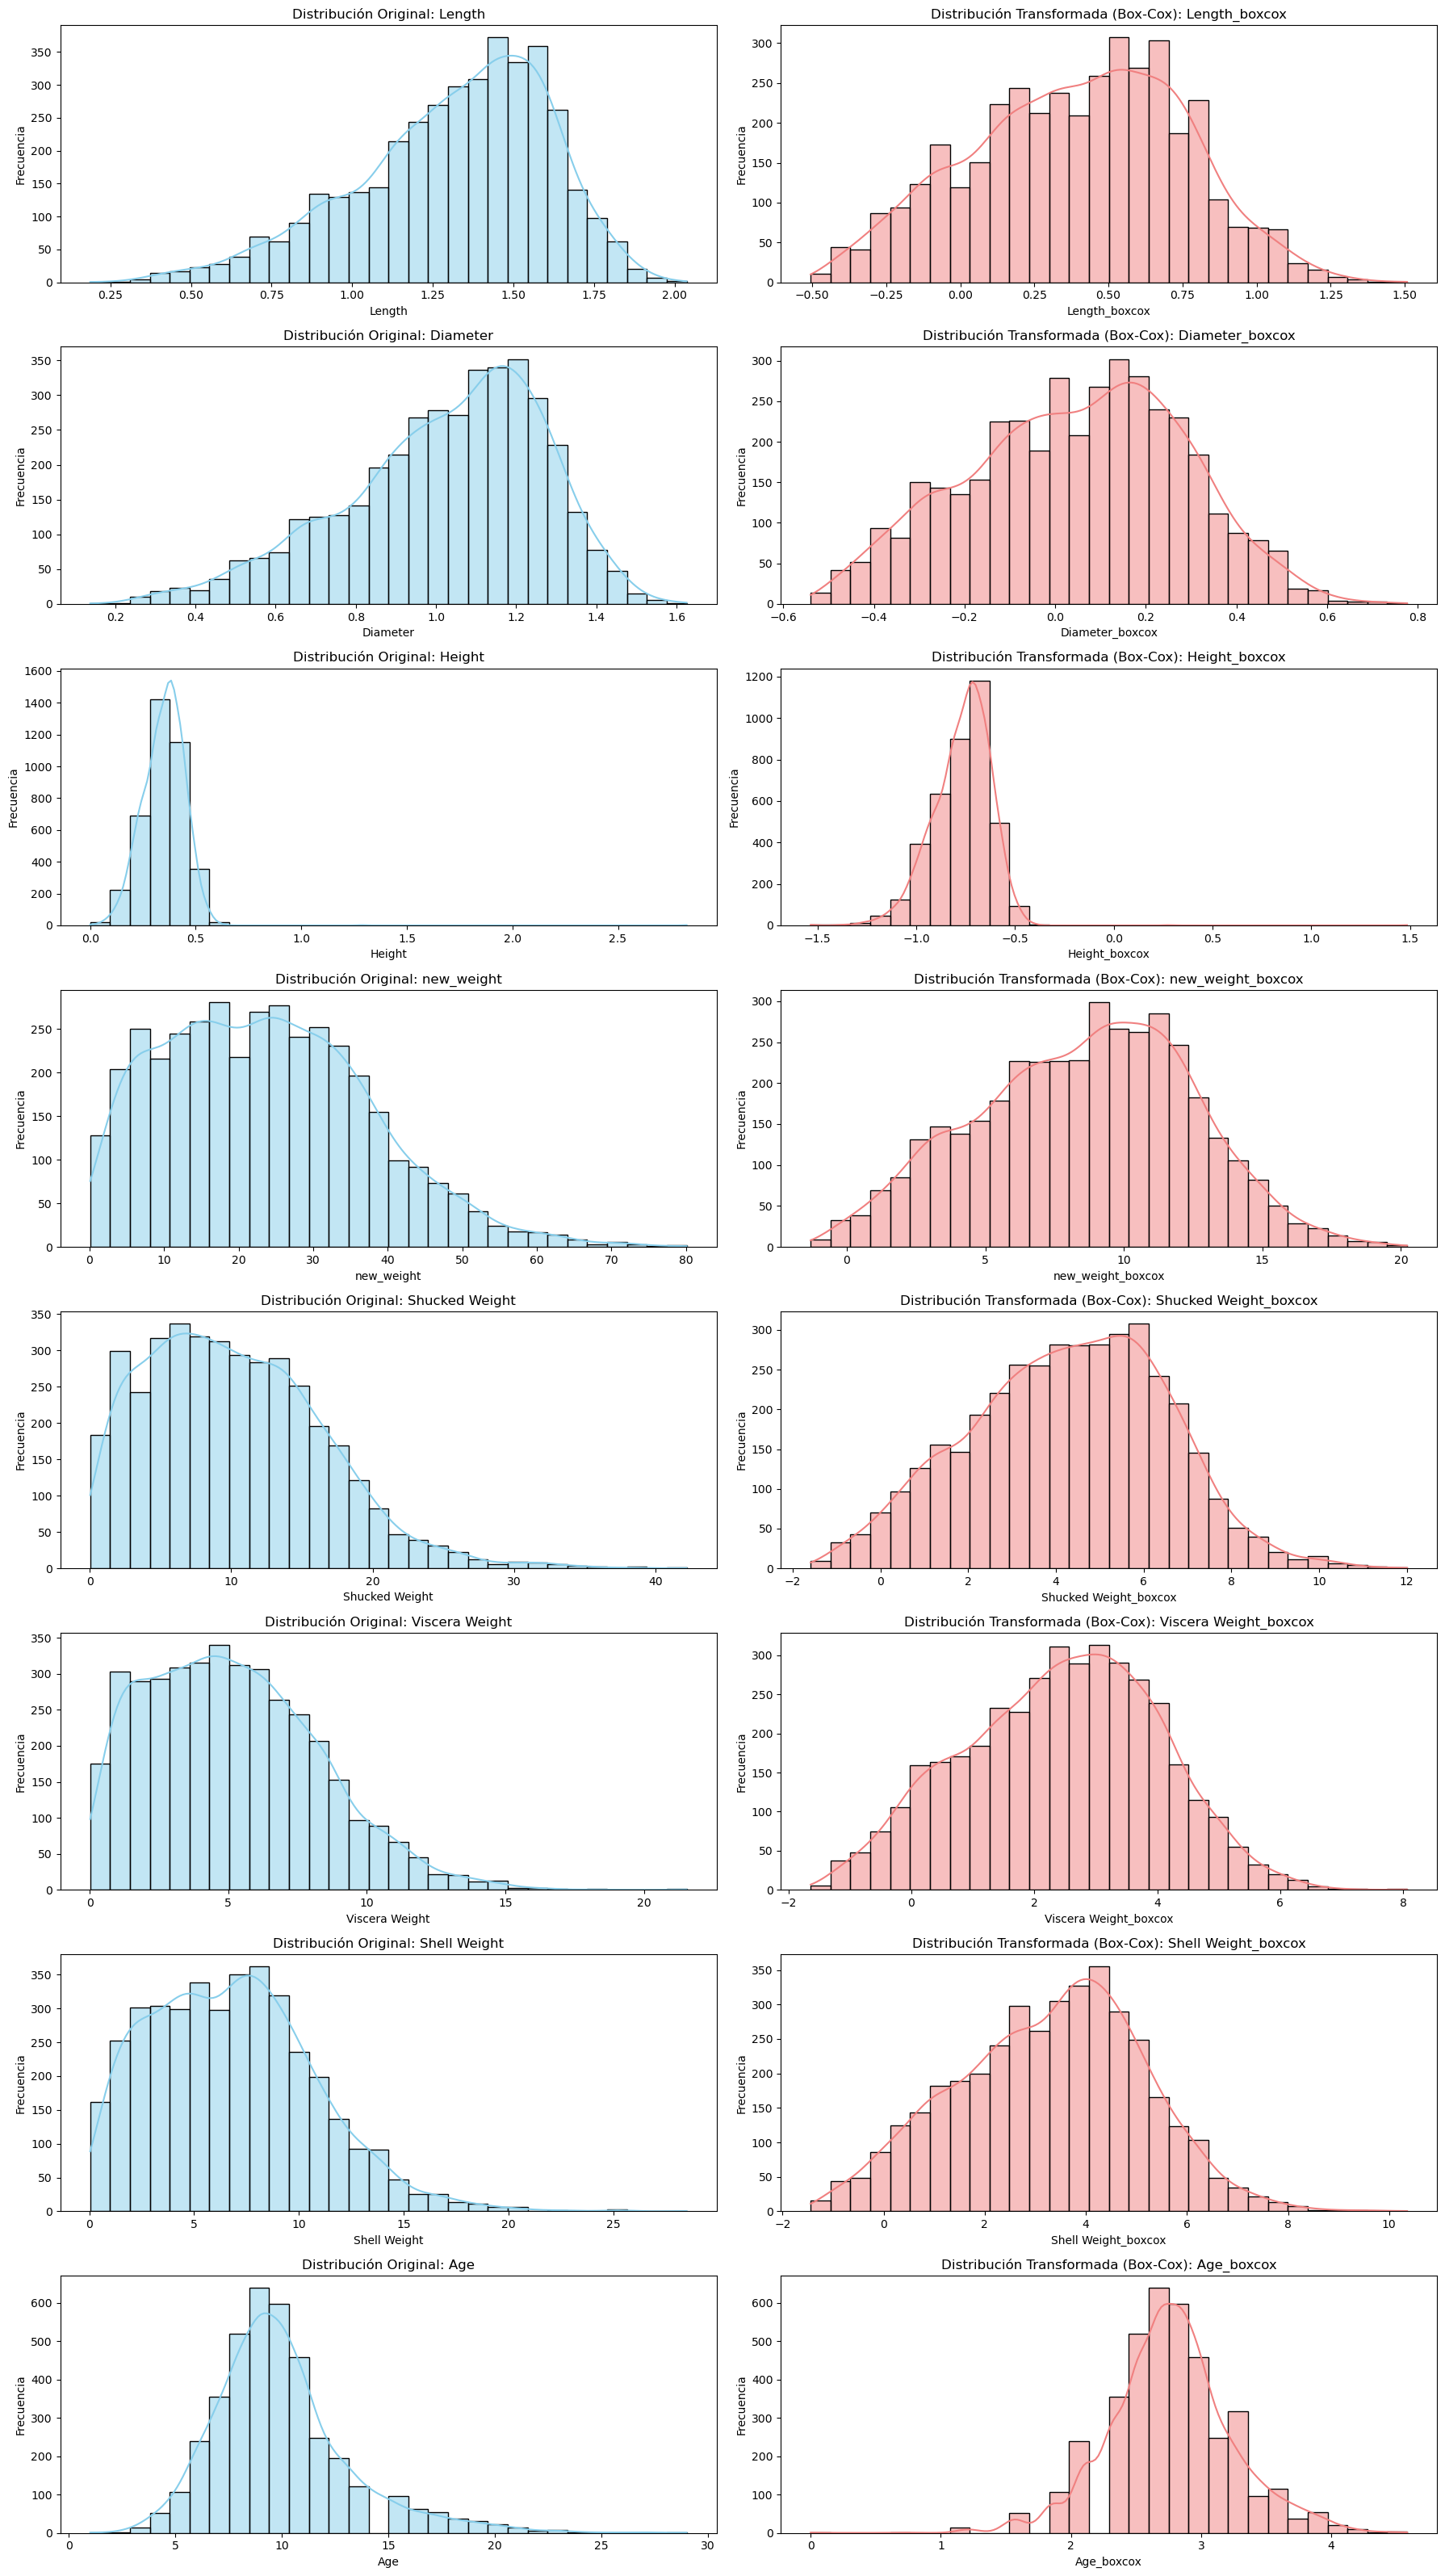


---
## Matriz de Correlación
---


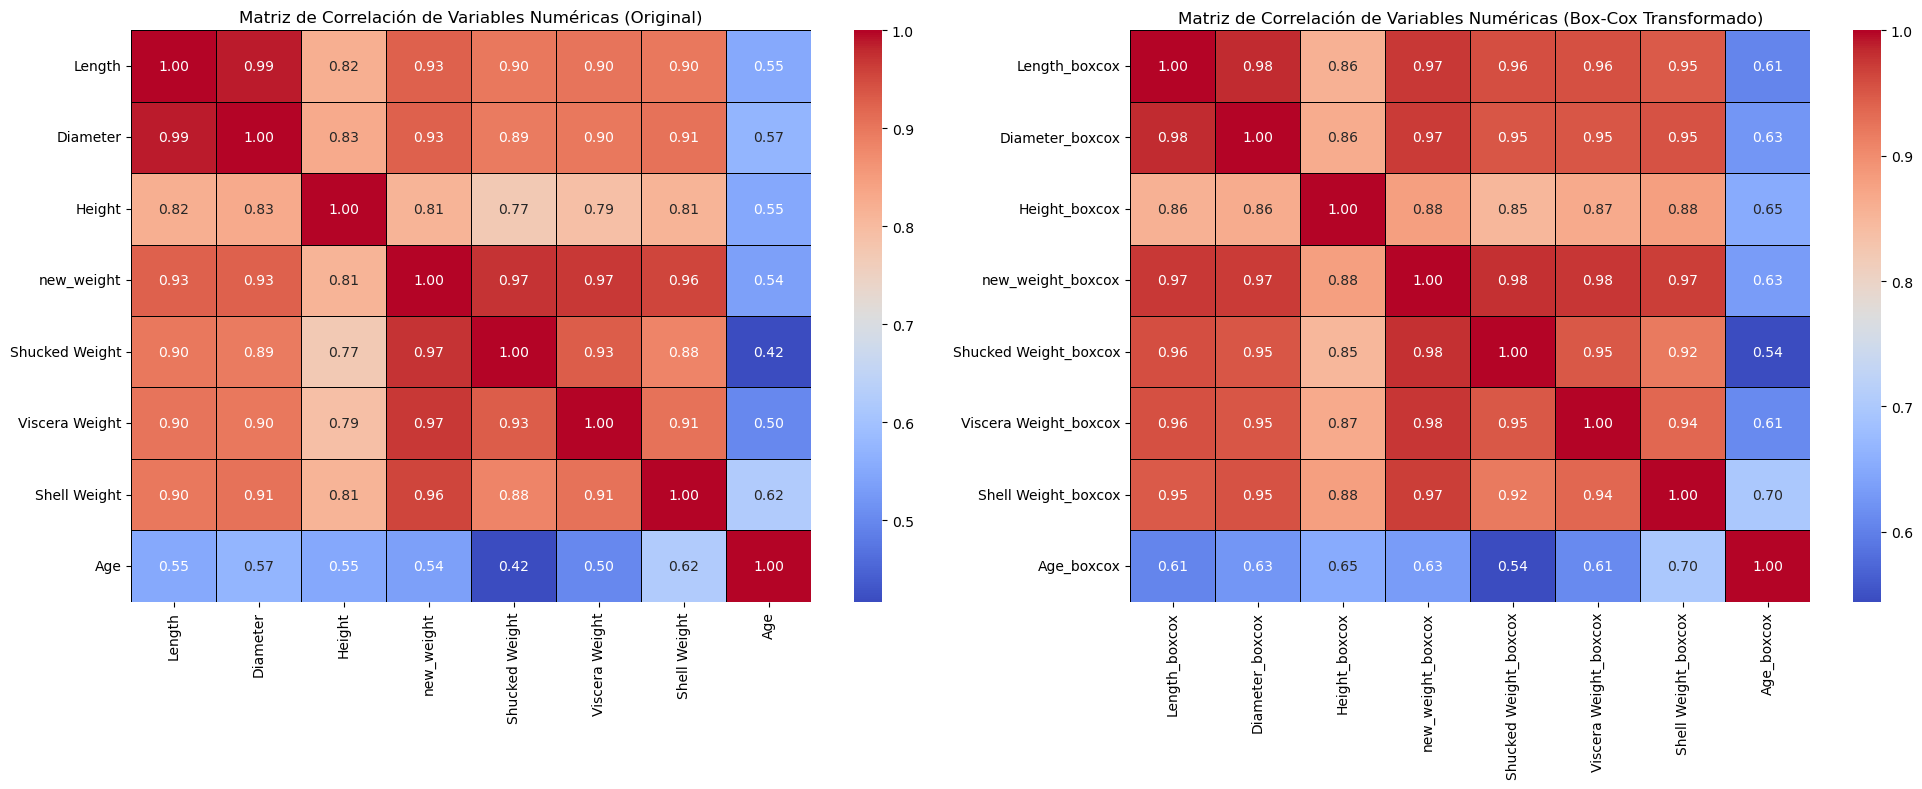

In [9]:
# Crear una copia del DataFrame para no modificar el original
df_transformed = df_crabs.copy()

# Variables a transformar
variables_a_transformar = ['Length', 'Diameter', 'Height', 'new_weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']

# Aplicar la transformación Box-Cox y crear nuevas columnas para las transformadas
print("# Aplicando Transformación Box-Cox...")
for var in variables_a_transformar:
    # Box-Cox requiere valores estrictamente positivos.
    # Si hay ceros, se añade una pequeña constante para evitar el ValueError.
    if (df_transformed[var] <= 0).any():
        print(f"Advertencia: La columna '{var}' contiene valores no positivos (cero o negativos). "
              f"Se le sumará una pequeña constante para aplicar Box-Cox.")
        # Añadir una constante muy pequeña para hacer los valores estrictamente positivos.
        # np.finfo(float).eps es el número de máquina más pequeño representable,
        # lo que asegura que la suma es mínima y no distorsiona demasiado los datos.
        df_transformed[f'{var}_boxcox'], _ = boxcox(df_transformed[var] + np.finfo(float).eps)
    else:
        # Si todos los valores son positivos, aplicar Box-Cox directamente
        df_transformed[f'{var}_boxcox'], _ = boxcox(df_transformed[var])
print("Transformación Box-Cox aplicada exitosamente.")


print("\n---")
print("## Visualización de Variables Originales vs. Transformadas (Box-Cox)")
print("---")

# Configurar el tamaño de la figura para una mejor visualización
plt.figure(figsize=(18, 4 * len(variables_a_transformar)))

for i, var in enumerate(variables_a_transformar):
    # Fila para la variable original
    plt.subplot(len(variables_a_transformar), 2, 2*i + 1)
    sns.histplot(df_crabs[var], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribución Original: {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

    # Fila para la variable transformada (Box-Cox)
    plt.subplot(len(variables_a_transformar), 2, 2*i + 2)
    sns.histplot(df_transformed[f'{var}_boxcox'], kde=True, bins=30, color='lightcoral')
    plt.title(f'Distribución Transformada (Box-Cox): {var}_boxcox')
    plt.xlabel(f'{var}_boxcox')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


print("\n---")
print("## Matriz de Correlación")
print("---")

# Obtener los nombres de las columnas transformadas
variables_transformadas_nombres = [f'{var}_boxcox' for var in variables_a_transformar]

# Crear la figura con dos subplots para las matrices de correlación
plt.figure(figsize=(20, 8))

# Subplot para la matriz de correlación de df_crabs (original)
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer subplot
correlation_matrix_original = df_crabs[variables_a_transformar].corr()
sns.heatmap(correlation_matrix_original, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black') # Añadimos líneas para mayor claridad
plt.title('Matriz de Correlación de Variables Numéricas (Original)')

# Subplot para la matriz de correlación de df_transformed (Box-Cox)
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo subplot
correlation_matrix_transformed = df_transformed[variables_transformadas_nombres].corr()
sns.heatmap(correlation_matrix_transformed, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black') # Añadimos líneas para mayor claridad
plt.title('Matriz de Correlación de Variables Numéricas (Box-Cox Transformado)')

plt.tight_layout() # Ajusta automáticamente los parámetros del subplot para que encajen
plt.show()

### Conclusiones:
* Primero que todo al contratar los graficos de histograma de cada variable antes y depues de la transformacion Box-Cox notamos que esta ayudo a reducir el sesgo para cada una de las distribuciones haciendo que cada una de ellas se asemeje mas a una distribucion normal
* Tambien al graficar las matrices de correlacion notamos que la matriz de correlacion de las variables ya transformadas presenta una mayor correlacion que la matriz de variables sin transformar esto sera de ayuda en la implementacion del modelo ya que para el mismo trabajaremos con los datos ya trasformados

---
## Impacto de la Transformación Box-Cox en la Relación entre Variables

En la **Parte 2** de nuestro análisis exploratorio, utilizamos un `pairplot` para visualizar las relaciones entre varias variables clave en nuestro dataset de cangrejos. Observamos patrones interesantes, y desde entonces, la idea de construir un **modelo de regresión lineal** que use `new_weight` para predecir `Shucked Weight` (peso de la carne), `Viscera Weight` (peso de las vísceras) y `Shell Weight` (peso del caparazón) se ha vuelto una solución prometedora para nuestra problemática inicial.

Hemos discutido previamente cómo la **transformación Box-Cox** ayuda a que las distribuciones individuales de las variables se acerquen a la normalidad y cómo esto se refleja en las matrices de correlación, a menudo aumentando la linealidad de las relaciones. Sin embargo, para un modelo de regresión lineal, no solo es importante que las variables estén distribuidas normalmente, sino también que la **relación entre la variable predictora y las variables objetivo sea lo más lineal y homocedástica posible**.

### La Duda Persiste: ¿Cómo Afectó Directamente la Transformación a estas Relaciones?

Para responder a esta pregunta de manera visual y directa, vamos a examinar específicamente la relación entre `new_weight` y cada una de las variables objetivo (`Shucked Weight`, `Viscera Weight`, `Shell Weight`) **antes y después de aplicar la transformación Box-Cox**. A través de gráficos de dispersión con líneas de regresión, podremos observar de cerca los siguientes puntos:

* **Linealidad:** ¿Se vuelven las relaciones más rectas después de la transformación? Una relación más lineal es fundamental para que un modelo de regresión lineal funcione de manera óptima y sus coeficientes sean fácilmente interpretables.
* **Homocedasticidad:** ¿Se reduce la dispersión de los puntos a medida que aumenta el valor de las variables? Buscamos una dispersión de errores constante a lo largo de la línea de regresión, y la transformación Box-Cox a menudo ayuda a lograr esto. Una varianza constante (homocedasticidad) es un supuesto clave para que las estimaciones de los mínimos cuadrados ordinarios (OLS) sean eficientes y sus errores estándar sean válidos.
* **Impacto por Sexo:** Al mantener la distinción por `Sex` (`hue`), podremos ver si la transformación beneficia de manera uniforme a todos los grupos de cangrejos o si hay diferencias notables en cómo afecta la linealidad y la homocedasticidad para machos, hembras e inmaduros.

A continuación, visualizaremos estas comparaciones para entender mejor el impacto de la transformación Box-Cox en las relaciones específicas que son más relevantes para nuestro modelo de regresión.

---


---
## Relación de 'new_weight' con Pesos de Partes: Original vs. Transformado (Box-Cox)
---


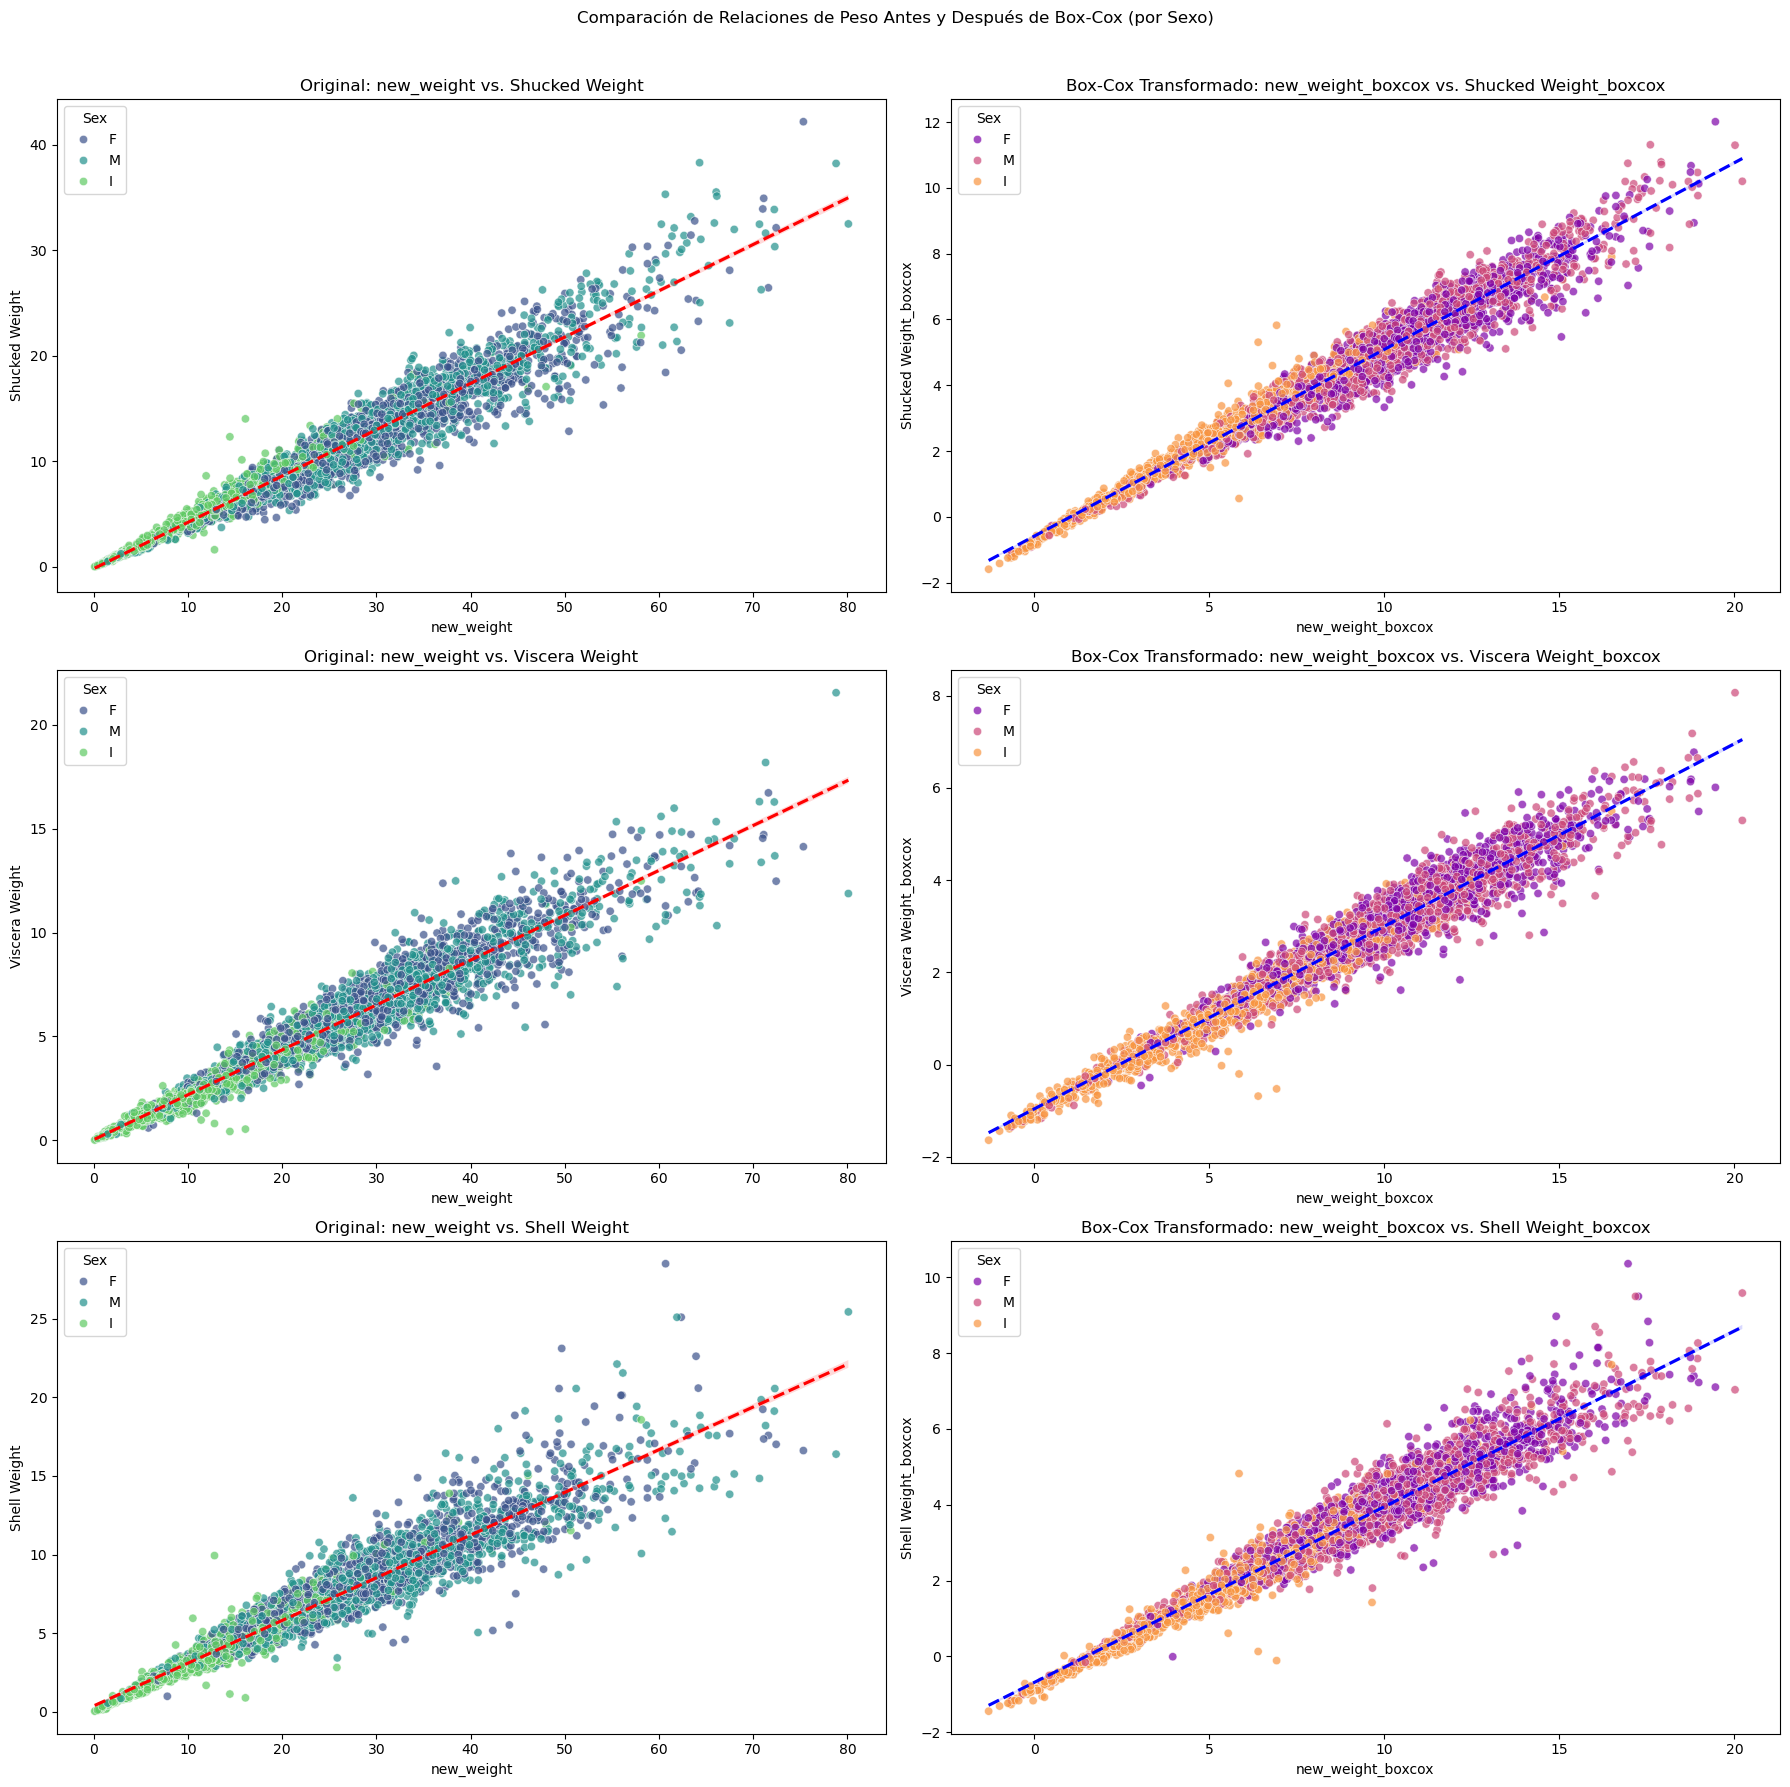

In [10]:
# --- Generación de Scatter Plots Específicos (Original vs. Transformado) ---

print("\n---")
print("## Relación de 'new_weight' con Pesos de Partes: Original vs. Transformado (Box-Cox)")
print("---")

# Definir los pares de variables que se visualizarán: new_weight vs. cada peso de parte
selected_pairs = [
    ('new_weight', 'Shucked Weight'),
    ('new_weight', 'Viscera Weight'),
    ('new_weight', 'Shell Weight'),
]

# Calcular el número total de subplots necesarios (2 por cada par: original y transformado)
num_plots_per_pair = 2 # Original y Transformado
num_total_subplots = len(selected_pairs) * num_plots_per_pair

# Ajustar el diseño de la figura para 2 columnas
ncols = 2
nrows = (num_total_subplots + ncols - 1) // ncols # Calcula las filas necesarias

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6 * nrows)) # Ajusta el tamaño de la figura para una mejor visualización

# Aplanar el array de axes si tiene más de 1 dimensión para facilitar la iteración
if nrows > 1:
    axes = axes.flatten()
elif ncols == 1: # Si solo hay una columna y una fila
    axes = [axes]
else: # Si solo hay una fila y múltiples columnas
    pass

plot_idx = 0
for y_var in [pair[1] for pair in selected_pairs]: # Iteramos solo sobre las variables Y
    x_var = 'new_weight' # La variable X siempre será 'new_weight'

    # --- Scatter Plot Original ---
    ax_original = axes[plot_idx]
    sns.scatterplot(data=df_crabs, x=x_var, y=y_var, hue='Sex', palette='viridis', alpha=0.7, ax=ax_original)
    sns.regplot(data=df_crabs, x=x_var, y=y_var, scatter=False, color='red', ax=ax_original, line_kws={'linestyle':'--'}) # Línea de regresión
    ax_original.set_title(f'Original: {x_var} vs. {y_var}')
    ax_original.set_xlabel(x_var)
    ax_original.set_ylabel(y_var)
    ax_original.legend(title='Sex')
    plot_idx += 1

    # --- Scatter Plot Transformado ---
    ax_transformed = axes[plot_idx]
    x_var_boxcox = f'{x_var}_boxcox'
    y_var_boxcox = f'{y_var}_boxcox'
    sns.scatterplot(data=df_transformed, x=x_var_boxcox, y=y_var_boxcox, hue='Sex', palette='plasma', alpha=0.7, ax=ax_transformed)
    sns.regplot(data=df_transformed, x=x_var_boxcox, y=y_var_boxcox, scatter=False, color='blue', ax=ax_transformed, line_kws={'linestyle':'--'}) # Línea de regresión
    ax_transformed.set_title(f'Box-Cox Transformado: {x_var_boxcox} vs. {y_var_boxcox}')
    ax_transformed.set_xlabel(x_var_boxcox)
    ax_transformed.set_ylabel(y_var_boxcox)
    ax_transformed.legend(title='Sex')
    plot_idx += 1

# Eliminar ejes extra si el número de subplots no llena completamente la última fila
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta el layout para que los títulos no se superpongan
plt.suptitle('Comparación de Relaciones de Peso Antes y Después de Box-Cox (por Sexo)', y=0.99) # Título general
plt.show()

### Conclusiones


### Observaciones de los Scatter Plots:
- Fijemonos cómo la **dispersión de los puntos** en los gráficos transformados se vuelve más **uniforme** a lo largo de la línea de regresión. Esto es una mejora en la **homocedasticidad**, un supuesto clave para la regresión lineal."
- La **relación entre `new_weight` y cada peso de parte** tiende a ser más **lineal** en los gráficos transformados. Esto facilita que el modelo de regresión capture mejor la relación subyacente."
- La distinción `por Sexo` (`hue`) te permite ver si estas mejoras aplican uniformemente a machos, hembras o de sexo desconocido  y si hay diferencias significativas entre los grupos."

## Conclusiones finales previas al modelo

Con toda la informacion extraida y sin perder de vista nuestro problema inicial podemos dar solucion al mismo a traves de un modelo de regresion lineal (hay una carpeta llamada <u>3-Modelo_Regresion_Lineal</u> en la que hablo de sus detalles del mismo) usando como variable predictora a 'new_weight' y como variables a predecir 'Shucked Weight', 'Viscera Weight', 'Shell Weight'.